# Audio Moderator V.4
Aug 25, 2020

Anyone who has ever traveled to a place where their native language isn't spoken, or who has ever tried to learn a foreign language, has inevitably come across Machine Translation applications. Besides travel and education, translation is essential in business localization efforts, as well as in content moderation on social media platforms. It's straightforward to use a translation platform like Google Translate to inspect text comments and messages. But if a user posts video or audio content, this can be more difficult to monitor. This project aims to translate Chinese audio to English text to assist in content moderation and foreign language audio/video sharing. The first part (and bulk) of the project consists of the language translation model, and the second part includes a speech to translation function with some example translations.

## Set-up

In addition to standard imports, parsing Chinese requires a conversion function to change all characters to either simplified or traditional script, as well as a parsing function to break character strings at word boundaries. Chinese text is written without spaces, so without splitting into individual characters (unigrams), or at word boundaries (one or more character strings), each sentence would be counted as unique during tokenization.

I use Keras with TensorFlow backend to build the model. Originally I also used a custom Attention decoder layer from modified slightly from Zafarali Ahmed's [Keras Attention](https://github.com/datalogue/keras-attention). The modification is a [_time_distributed_dense](https://github.com/datalogue/keras-attention/issues/15) function added to the layer code since this was deprecated in the latest version of Keras. There have since been further deprecations, so this has been removed.

In [1]:
#imports

#general
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
from numpy.random import rand
from numpy.random import shuffle
from pickle import load
from pickle import dump

#text cleaning
import string
import re
from unicodedata import normalize
import jieba #cut Chinese at word boundaries
!pip install chinese-converter # Reinstall on new Colab notebooks
import chinese_converter #convert to simplified or traditional characters

#plotting and style
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.simplefilter('ignore')

#deep learning
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout, GlobalMaxPooling1D, SpatialDropout1D
#from keras.layers import Attention
#from attention_decoder2 import AttentionDecoder
from keras.models import load_model
from keras.utils import CustomObjectScope

#scoring
from nltk.translate.bleu_score import corpus_bleu

print('Done!')

Done!


## Cleaning and Saving the Data

### Functions for Loading, Cleaning, and Saving

The comes from the [Tatoeba Project](https://tatoeba.org/eng) bilingual sentence pairs, available [here](http://www.manythings.org/anki/). The 22,075
sentence pairs in the Chinese-English set have mostly short, but varied lengths, and little to no specialist vocabulary. The data comes in a tab-delineated .txt format consisting of three parts: and English sentence, the equivalent sentence written in simplified or traditional Chinese, and an attribution to the human translator on the project website. An example looks like the following:

“Show me an example.   给我个例子。   CC-BY 2.0 (France) Attribution: tatoeba.org #395402 (CK) & #490074 (fucongcong)”

Chinese and English are cleaned separately in the cleaning function. For the English sentence cleaning, I used string methods to lowercase all words and removed punctuation with regular expressions. For the Chinese, I used [Jieba](https://github.com/fxsjy/jieba) to split the data at word boundaries. This enables us to tokenize Chinese as we would for languages written with alphabets. I also cleaned out Chinese punctuation using regular expressions, and removed the attribution section.

Stemming, lemmatization, and stop word removal were not performed, since ideally we would like the model to learn verb tense, plurals, correct article usage, and other features that contribute to making the translation seem as human as possible. In a situation with more training time and RAM, we might choose to leave in features such as punctuation and capitalization too, since the model would also learn these.


In [2]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# split a loaded document into sentences
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines]
	return pairs

#clean a list of lines
def clean_pairs(lines):
  english = []
  chinese = []
  for pair in lines:
    eng = pair[0].lower()
    eng1 = re.sub(r'[.,?!]', '', eng)
    chi = chinese_converter.to_simplified(pair[1])
    chi1 = jieba.cut(chi, cut_all=False)
    chi2 = ' '.join (chi1)
    chi2 = re.sub(r'[^\w\s]', '', chi2)
    chi2 = chi2.rstrip()
    english.append(eng1)
    chinese.append(chi2)
  return english, chinese

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
  
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)
 
print('Done!')

Done!


### Loading and Cleaning the Raw Data

We can see that the original sentences have punctuation and an attribution statement. The cleaned data removes this and separates the Chinese by words.

In [3]:
# load dataset
filename = 'cmn.txt'
doc = load_doc(filename)
# split into english-chinese pairs
pairs = to_pairs(doc)
# clean sentences
eng_clean_pairs, chi_clean_pairs = clean_pairs(pairs)
print()
print('Original sentence example: ', pairs[0])
print('Cleaned English example: ', eng_clean_pairs[10])
print('Cleaned Chinese example: ', chi_clean_pairs[100])

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.608 seconds.
Prefix dict has been built successfully.



Original sentence example:  ['Hi.', '嗨。', 'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #891077 (Martha)']
Cleaned English example:  got it
Cleaned Chinese example:  我 迷失 了


In [4]:
clean_pairs = [[i, j] for i, j in zip(eng_clean_pairs,chi_clean_pairs)]

# spot check
for i in range(20):
	print('[%s] => [%s]' % (clean_pairs[i][0], clean_pairs[i][1]))

[hi] => [嗨]
[hi] => [你好]
[run] => [你 用 跑 的]
[wait] => [等等]
[wait] => [等 一下]
[hello] => [你好]
[i try] => [让 我 来]
[i won] => [我 赢 了]
[oh no] => [不会 吧]
[cheers] => [干杯]
[got it] => [你 懂 了 吗]
[he ran] => [他 跑 了]
[hop in] => [跳进来]
[i quit] => [我 退出]
[i'm ok] => [我 没事]
[listen] => [听 着]
[no way] => [不 可能]
[no way] => [没门]
[really] => [你 确定]
[try it] => [试试 吧]


### Save Cleaned Text

We save the data for later use in the clean state.

In [5]:
# save clean pairs to file
save_clean_data(clean_pairs, 'english-chinese.pkl')

Saved: english-chinese.pkl


### Save Train and Test Sets

Here I split the data into training and testing sets. The full dataset is not utilized due to RAM runtime restrictions in Google Colab. However, I use the maximum number possible. The data is split 87.5% for training and 12.5% for testing. The skew towards the training data is an effort to expose the model to as much vocabulary as possible during the training and reduce the amount of unseen vocabulary in the testing.

In [6]:
# load dataset
raw_dataset = load_clean_sentences('english-chinese.pkl')
 
# reduce dataset size
n_sentences = 18000
dataset = raw_dataset[:n_sentences]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:16000], dataset[16000:]
# save
save_clean_data(dataset, 'english-chinese-both.pkl')
save_clean_data(train, 'english-chinese-train.pkl')
save_clean_data(test, 'english-chinese-test.pkl')
print()
print('Total sentences in complete dataset: ', len(raw_dataset))
print('Original data example: ', raw_dataset[0])
#print(dataset[0])
print('Example from training set: ', train[0])
print('Example from testing set: ', test[0])

Saved: english-chinese-both.pkl
Saved: english-chinese-train.pkl
Saved: english-chinese-test.pkl

Total sentences in complete dataset:  22075
Original data example:  ['hi', '嗨']
Example from training set:  ['sydney is far from here', '悉尼 离 这里 很 远']
Example from testing set:  ['he has never played golf', '他 从没 打 过 高尔夫球']


## Data Exploration

### Functions to Tokenize and Explore Clean Sentences

In [7]:
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)
 
print('Done!')

Done!


### Dataset Size

Separate Chinese and English data for descriptive statistical analysis.

In [8]:
 # load datasets
dataset = load_clean_sentences('english-chinese-both.pkl')
train = load_clean_sentences('english-chinese-train.pkl')
test = load_clean_sentences('english-chinese-test.pkl')

print(dataset[:2])
print(train[:2])
print(test[:2])
print(len(dataset))
print(len(train))
print(len(test))
eng_data = [i[0] for i in dataset]
chi_data = [i[1] for i in dataset]
eng_train = [i[0] for i in train]
chi_train = [i[1] for i in train]
eng_test = [i[0] for i in test]
chi_test = [i[1] for i in test]

print(eng_data[:5])
print(chi_data[:5])

[['sydney is far from here', '悉尼 离 这里 很 远'], ['you are not a coward', '您 不是 个 懦夫']]
[['sydney is far from here', '悉尼 离 这里 很 远'], ['you are not a coward', '您 不是 个 懦夫']]
[['he has never played golf', '他 从没 打 过 高尔夫球'], ['when did she promise to meet him', '她 答应 几时 见 他']]
18000
16000
2000
['sydney is far from here', 'you are not a coward', 'i support political reform', "we'll be busy", 'i met an old woman']
['悉尼 离 这里 很 远', '您 不是 个 懦夫', '我 支持 政治 改革', '我们 会 很 忙', '我 遇见 了 一位 老妇人']


### Vocabulary Size and Average Sentence Length

Here I compute the vocabulary size for each language; that is, the number of unique words in the vocabulary. I also compute the maximum number of words in a sentence for each language, and the average number of words in a sentence for each language. The minumum number of words in a sentence in 1 for both languages, as we can see in the first sentence of the dataset: "Hi/嗨"

In [9]:
# prepare english tokenizer
eng_tokenizer = create_tokenizer(eng_data)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(eng_data)
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare chinese tokenizer
chi_tokenizer = create_tokenizer(chi_data)
chi_vocab_size = len(chi_tokenizer.word_index) + 1
chi_length = max_length(chi_data)
print('Chinese Vocabulary Size: %d' % chi_vocab_size)
print('Chinese Max Length: %d' % (chi_length))
#print(eng_tokenizer[0])
#print(chi_tokenizer[0])

eng_data_lengths = [] 
chi_data_lengths = [] 

for i in eng_data: 
      eng_data_lengths.append(len(i.split())) 

for i in chi_data: 
      chi_data_lengths.append(len(i.split())) 


eng_avg_sents = (sum(eng_data_lengths))/(len(eng_data))
chi_avg_sents = (sum(chi_data_lengths))/(len(chi_data))

print('Average English sentence length: ', eng_avg_sents)
print('Average Chinese sentence length: ', chi_avg_sents)

English Vocabulary Size: 5176
English Max Length: 10
Chinese Vocabulary Size: 8600
Chinese Max Length: 16
Average English sentence length:  5.486277777777778
Average Chinese sentence length:  5.0895


We can plot the distribution of sentence lengths over the dataset for each language.

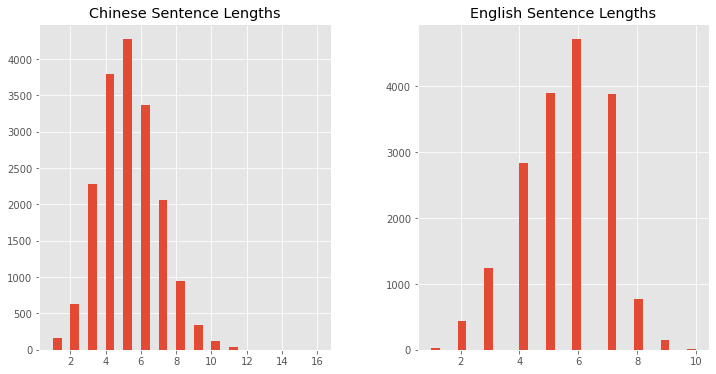

In [10]:
#histograms of sentence lengths
length_df = pd.DataFrame({'English Sentence Lengths':eng_data_lengths, 'Chinese Sentence Lengths':chi_data_lengths}) 
length_df.hist(bins=30, figsize=(12,6)) 
plt.show()

### Unique Words in Dataset

Next, I calculate the number of words in the vocabulary of each language that only occur once, as well as print a list of the first hundred singly-occuring words as an example. I also show the number of words in each language that occur more than 100 times in the dataset. Finally I show the percentage of single words in relation to the entire vocabulary size. 

Words that occur only once can lower the accuracy of the predictions, especially when they appear in the test data, meaning that the model has never seen the words before. When the statistical language model has multiple occurences of vocabulary words, the RNN can then become more nuanced in the output.

In [11]:
#tokens that only appear once
eng_single_words = [w for w,c in eng_tokenizer.word_counts.items() if c == 1]
chi_single_words = [w for w,c in chi_tokenizer.word_counts.items() if c == 1]

eng_frequent_words = [w for w,c in eng_tokenizer.word_counts.items() if c > 100]
chi_frequent_words = [w for w,c in chi_tokenizer.word_counts.items() if c > 100]

print('English single words: ', len(eng_single_words))
print(eng_single_words[:100])
print()
print('Chinese single words: ', len(chi_single_words))
print(chi_single_words[:100])
print()
print('English frequent words: ', len(eng_frequent_words))
print(eng_frequent_words[:100])
print()
print('Chinese frequent words: ', len(chi_frequent_words))
print(chi_frequent_words[:100])
print()
print('Percent of single words in English vocab: ', (len(eng_single_words)/eng_vocab_size)*100)
print('Percent of single words in Chinese vocab: ', (len(chi_single_words)/chi_vocab_size)*100)

English single words:  2045
['reform', 'released', 'relieved', 'ale', 'string', 'membership', 'joining', 'highly', "beauty's", 'require', 'geography', 'dived', 'stings', 'survival', 'unknown', 'atrocious', 'locking', 'heavily', 'pendant', 'absconded', 'seine', 'handbag', 'comic', 'california', '40000', 'leader', 'sole', 'swept', 'reagan', 'underage', 'falls', 'emotions', 'tense', 'depressing', 'gently', 'miracles', 'justifies', 'convince', 'guts', 'observe', 'affection', 'obviously', 'ladies', 'hudson', 'senior', 'assume', 'rats', 'inevitable', 'putt', 'reflection', "other's", '3000', 'comb', 'farsighted', 'lid', 'bulb', 'utterly', 'harajuku', 'meditate', 'decency', 'spy', 'clown', 'progressing', 'forte', 'threat', 'richmond', 'email', 'ancient', 'update', 'website', 'gestalt', 'therapy', 'notebooks', 'bathtub', 'glamorous', 'wow', 'significance', '1950', 'hyogo', 'leaned', 'anonymous', 'verge', 'lectures', 'dawn', 'thrown', 'era', 'atomic', 'yawned', 'preferred', 'invested', 'stocks',

I show a plot of word frequency distributions over each language's vocabulary. Words that occur only once appear far more frequently in both language than words that occur more than 1000 times.

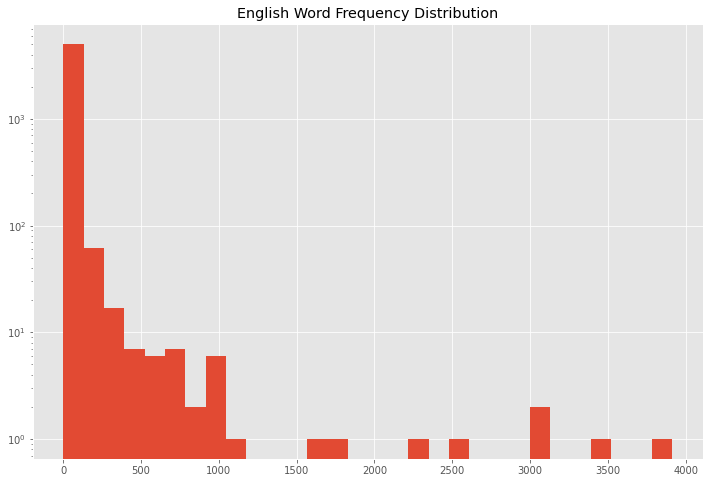

In [12]:
#English distribution of word frequencies
eng_words_unique = [w for w,c in eng_tokenizer.word_counts.items()]
eng_words_counts = [c for w,c in eng_tokenizer.word_counts.items()]
df_eng_frequency = pd.DataFrame(zip(eng_words_unique, eng_words_counts), columns=['words', 'frequency'])
df_eng_frequency['frequency'].hist(bins=30, figsize=(12,8))
plt.yscale('log')
plt.title('English Word Frequency Distribution')
plt.show()

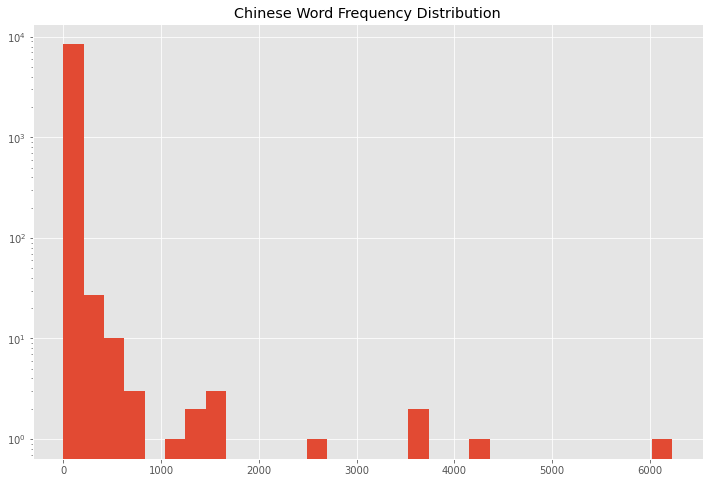

In [13]:
#Chinese distribution of word frequencies
chi_words_unique = [w for w,c in chi_tokenizer.word_counts.items()]
chi_words_counts = [c for w,c in chi_tokenizer.word_counts.items()]
df_chi_frequency = pd.DataFrame(zip(chi_words_unique, chi_words_counts), columns=['words', 'frequency'])
df_chi_frequency['frequency'].hist(bins=30, figsize=(12,8))
plt.yscale('log')
plt.title('Chinese Word Frequency Distribution')
plt.show()

## Prepare Data for Neural Machine Translation

### Functions to Encode Sentences and Define the Model

In order to feed the data into the model for training, all text data must be encoded into numeric sequences and padded so that all sequences are the same length. Using Keras tokenizer, the vocabulary for each language is assigned an index, and then each word in a sentence is replaced with its corresponding index. These numeric sequences are then padded with zeroes on the end so that each sequence will have a total length equal to the maximum sentence length. Target sequences (y) are also one-hot encoded to vectors of ones and zeroes the size of the maximum vocabulary. 

The model consists of an Bidirectional LSTM input layer with a dropout rate of 50% to reduce overfitting, a Repeat Vector layer to add a third dimension, and an LSTM decoder layer. An LSTM (Long Short Term Memory) is a type of recurrent neural network that learns dependencies better than other kinds of RNNs. The cell state of an LSTM contains information gateways that learn to keep or discard information over time-steps. Because of this, LSTMs are well-suited to sequence-to-sequence problems, like Machine Translation. A bidirectional LSTM extends this power by reading both backwards and forwards sequential inputs.

Note: In the previous version of this model, I used an Attention decoder which extends decoding power by allowing the model to soft-search input encodings and make predictions about the following target word. In other words, it identifies which parts of the input are relevant for producing the output. However, since July when I implemented it, it seems that Keras has deprecated one of the layers (Recurrent) that was used in the custom Attention layer. I have not yet found out how to replace this, nor have I successfully been able to implement the new Attention layer from Keras. In general, results were slightly better in the previous iteration with the Attention decoder.

In [14]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X
 
# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y

# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	model.add(Bidirectional(LSTM(n_units, dropout=0.5)))
	#model.add(Bidirectional(LSTM(n_units, dropout=0.5, recurrent_dropout=0.5)))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, dropout=0.5, return_sequences=True))
	#model.add(Dropout(0.5))
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model
 	


# def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
# 	model = Sequential()
# 	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
# 	model.add(LSTM(n_units))
# 	model.add(Dropout(0.5))
# 	# model.add(LSTM(n_units))
# 	# model.add(Dropout(0.5))
# 	model.add(RepeatVector(tar_timesteps))
# 	#model.add(LSTM(n_units, return_sequences=True))
# 	# model.add(Dropout(0.5))
# 	#model.add(AttentionDecoder(n_units, tar_vocab))
# 	#model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
# 	return model

print('Done!')

Done!


### Encode and Pad Sequences

Sequences are encoded based on word indexing, and then target values are one-hot encoded.

In [15]:
# prepare training data
trainX = encode_sequences(chi_tokenizer, chi_length, chi_train)
trainY = encode_sequences(eng_tokenizer, eng_length, eng_train)
trainY = encode_output(trainY, eng_vocab_size)

print(trainX[0])
print(trainY[0])
print(trainX.shape)
print(trainY.shape)

[4178  528   45   13  582    0    0    0    0    0    0    0    0    0
    0    0]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
(16000, 16)
(16000, 10, 5176)


In [16]:
# prepare validation data
testX = encode_sequences(chi_tokenizer, chi_length, chi_test)
testY = encode_sequences(eng_tokenizer, eng_length, eng_test)
testY = encode_output(testY, eng_vocab_size)
 
print(testX[0])
print(testY[0])
print(testX.shape)
print(testY.shape)

[  5 517 180  74 888   0   0   0   0   0   0   0   0   0   0   0]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
(2000, 16)
(2000, 10, 5176)


### Define and Summarize Model

The model has 512 neurons in the layer. 50% are masked during each training epoch (dropout) to reduce overfitting weights. The Adam optimizer controls the rate of weight changes and adapts its learning rate with each iteration to optimize these.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 512)           4403200   
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              4198400   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 512)           3147776   
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 5176)          2655288   
Total params: 14,404,664
Trainable params: 14,404,664
Non-trainable params: 0
_________________________________________________________________
None


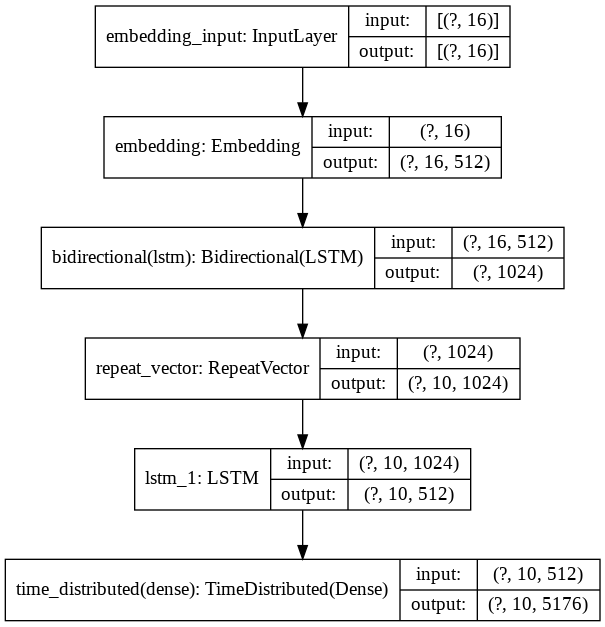

In [17]:
# define model
model = define_model(chi_vocab_size, eng_vocab_size, chi_length, eng_length, 512)
opt = keras.optimizers.Adam(learning_rate=0.003)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# summarize de_size, eng_vocab_size, chi_length, eng_length, 80)
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

### Fit and Train the Model

The model trains and validates on the test set over a set number of epochs, during which it updates its weights.

In [18]:
# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY, epochs=30, batch_size=100, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

Epoch 1/30

Epoch 00001: val_loss improved from inf to 3.40728, saving model to model.h5
160/160 - 15s - loss: 3.8169 - accuracy: 0.4731 - val_loss: 3.4073 - val_accuracy: 0.4970
Epoch 2/30

Epoch 00002: val_loss improved from 3.40728 to 3.25997, saving model to model.h5
160/160 - 13s - loss: 3.2884 - accuracy: 0.4980 - val_loss: 3.2600 - val_accuracy: 0.5117
Epoch 3/30

Epoch 00003: val_loss improved from 3.25997 to 3.10371, saving model to model.h5
160/160 - 13s - loss: 3.0738 - accuracy: 0.5183 - val_loss: 3.1037 - val_accuracy: 0.5321
Epoch 4/30

Epoch 00004: val_loss improved from 3.10371 to 2.97203, saving model to model.h5
160/160 - 13s - loss: 2.8555 - accuracy: 0.5393 - val_loss: 2.9720 - val_accuracy: 0.5474
Epoch 5/30

Epoch 00005: val_loss improved from 2.97203 to 2.87421, saving model to model.h5
160/160 - 13s - loss: 2.6479 - accuracy: 0.5566 - val_loss: 2.8742 - val_accuracy: 0.5588
Epoch 6/30

Epoch 00006: val_loss improved from 2.87421 to 2.77682, saving model to model

### Plot of Training

The plot of the traning shows improvement during each epoch for the training and testing data, although the testing data does not perform as well as the training data. The slowing of improvement of the testing data suggests some overfitting issues that still need to be addressed.

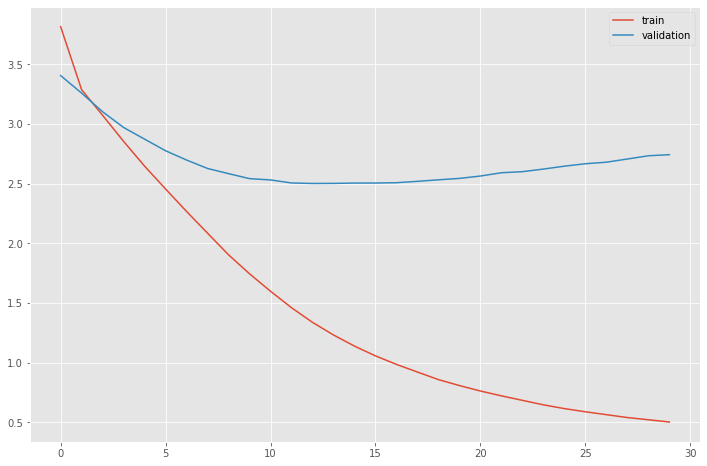

In [19]:
#plot of model training
plt.figure(figsize=(12,8))
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.legend(['train','validation']) 
plt.show()

## Model Evaluation

### Functions for Model Evaluation

Machine Translation quality is often evaluated using [BLEU scores](https://www.sdl.com/blog/understanding-mt-quality-bleu-scores.html#:~:text=The%20BLEU%20metric%20scores%20a,system%20is%20deemed%20to%20be.), so I have used this method to score my model as well. BLEU scoring follows a string-matching algorithm and compares matching ngrams in the predicted translation with human-translated target sentences. String matching cannot account for strings that are not identical but still semantically related, such as the same verb with different tenses, or synonyms. Additionally, human translators often produce a variety of translations for a single source sentence. Because difference in translations can occur, a BLEU score between 60% to 70% is generally thought to be good. 

In [20]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)
 
# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

print('Done!')

Done!


### Load and Prepare Data for Evaluation

In [21]:
 # load datasets
dataset = load_clean_sentences('english-chinese-both.pkl')
train = load_clean_sentences('english-chinese-train.pkl')
test = load_clean_sentences('english-chinese-test.pkl')

eng_data = [i[0] for i in dataset]
chi_data = [i[1] for i in dataset]
eng_train = [i[0] for i in train]
chi_train = [i[1] for i in train]
eng_test = [i[0] for i in test]
chi_test = [i[1] for i in test]

# prepare english tokenizer
eng_tokenizer = create_tokenizer(eng_data)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(eng_data)
# prepare chinese tokenizer
chi_tokenizer = create_tokenizer(chi_data)
chi_vocab_size = len(chi_tokenizer.word_index) + 1
chi_length = max_length(chi_data)
# prepare data
trainX = encode_sequences(chi_tokenizer, chi_length, chi_train)
testX = encode_sequences(chi_tokenizer, chi_length, chi_test)
 
print(dataset[0])
print(train[0])
print(chi_train[1])
print(trainX[0])

['sydney is far from here', '悉尼 离 这里 很 远']
['sydney is far from here', '悉尼 离 这里 很 远']
您 不是 个 懦夫
[4178  528   45   13  582    0    0    0    0    0    0    0    0    0
    0    0]


### Model Evaluation with BLEU Scoring

We can see below the string matching scores for 1-grams, 2-grams, 3-grams, and 4-grams for both training and testing data. In addition, we can see the kinds of translations actually produced. For the training data, we see some very accurate sentences, but also some mistakes. In the test data we see accurate translations more rarely, and many repeated words.

In [22]:
#load model
# with CustomObjectScope({'AttentionDecoder': AttentionDecoder}):
#     model = load_model('model.h5')
model = load_model('model.h5')

# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, [i[:2] for i in train]) 
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, [i[:2] for i in test])

train
src=[悉尼 离 这里 很 远], target=[sydney is far from here], predicted=[sydney is far here here]
src=[您 不是 个 懦夫], target=[you are not a coward], predicted=[you are not a coward]
src=[我 支持 政治 改革], target=[i support political reform], predicted=[i support political reform]
src=[我们 会 很 忙], target=[we'll be busy], predicted=[we busy busy]
src=[我 遇见 了 一位 老妇人], target=[i met an old woman], predicted=[i saw a an woman]
src=[我们 选 她 为 主席], target=[we elected her chairperson], predicted=[we elected her chairperson chairperson]
src=[我 喜欢 数学], target=[i like mathematics], predicted=[i like mathematics]
src=[囚犯 重获 自由], target=[the prisoner was released], predicted=[the prisoner was released]
src=[我 登广告 卖 我 的 车], target=[i advertised my car for sale], predicted=[i advertised my car car]
src=[现在 售票], target=[tickets are on sale now], predicted=[tickets are on sale now]
BLEU-1: 0.595853
BLEU-2: 0.439106
BLEU-3: 0.361984
BLEU-4: 0.235226
test
src=[他 从没 打 过 高尔夫球], target=[he has never played golf], predic

# Speech to Text to Translation

## Chinese Speech to Text

### Functions to Translate Speech

To implement a simple speech to text functionality, I used the python SpeechRecognition library, as well as pydub for playing any files, as well as converting various audio file types to .wav if necessary. 

I wrote new functions to convert a given .wav file to text in Chinese, then modified the cleaning function used previously to clean and split the Chinese text.

For each translation instance, I converted the cleaned text to a sequence, then predicted an output, both using previously defined functions.

In [23]:
#import libraries for speech
!pip install SpeechRecognition
!pip install pydub
import os
from pydub import AudioSegment
from pydub.playback import play
import speech_recognition as sr 
import IPython.display as ipd
print('done')

done


In [39]:
#convert mp3 to wav (if necessary)
# sound = AudioSegment.from_mp3("nounderstand1_mandarin.mp3")
# sound.export("I_dont_understand.wav", format="wav")

#play a given wav file example
wav_file = AudioSegment.from_file(file="I_dont_understand1.wav", format="wav")
ipd.Audio('I_dont_understand1.wav')

In [27]:
#functions

def clean_chinese(text):
  chinese = []
  chi = chinese_converter.to_simplified(text)
  chi1 = jieba.cut(chi, cut_all=False)
  chi2 = ' '.join(chi1)
  chi2 = re.sub(r'[^\w\s]', '', chi2)
  chi2 = chi2.rstrip()
  chinese.append(chi2)
  return chinese

def speech2text(audio_file):
  r = sr.Recognizer()
  with sr.AudioFile(audio_file) as source:
    audio = r.record(source)
    sst = r.recognize_google(audio, language='zh-CN')
  return sst

print('done')

done


### STT Translation Examples

Here are some sample translations. After loading the model, each translation contains the following steps: convert audio to text and print to show original text and quality of conversion, clean the Chinese text, convert cleaned text to numeric sequence, make a prediction with that sequence as input, display the prediction.

Audio files were sourced from [Omniglot](https://omniglot.com/language/phrases/mandarin.php), a public website with general information on languages, including survival phrases. The sentences chosen are simple, basic phrases.

In all cases speech was converted accurately to text, and the numerous mistakes in the translations were made at the prediction step due to inadequacies in the model. 



In [40]:
#load model
model = load_model('model.h5')

#translation of sentence "I don't understand" (我听不懂)
sst = speech2text('I_dont_understand1.wav')
print(sst)
cleaned_sst = clean_chinese(sst)
seq = encode_sequences(chi_tokenizer, chi_length, cleaned_sst)
pred = predict_sequence(model, eng_tokenizer, seq)
print(pred)

我听不懂
i can't parties


In [41]:
#translation of sentence "I don't understand" (我不明白)
sst = speech2text('I_dont_understand2.wav')
print(sst)
cleaned_sst = clean_chinese(sst)
seq = encode_sequences(chi_tokenizer, chi_length, cleaned_sst)
pred = predict_sequence(model, eng_tokenizer, seq)
print(pred)

我不明白
i don't understand


In [42]:
#translation of sentence "This woman will pay the bill" (这位女士会清单)
sst = speech2text('This_woman_will_pay_the_bill.wav')
print(sst)
cleaned_sst = clean_chinese(sst)
seq = encode_sequences(chi_tokenizer, chi_length, cleaned_sst)
pred = predict_sequence(model, eng_tokenizer, seq)
print(pred)

这位女士会清单
the police will marvels


In [43]:
#translation of sentence "Would you write it down please?" (麻烦你写一下，好不好)
sst = speech2text('can_you_please_write_this_down.wav')
print(sst)
cleaned_sst = clean_chinese(sst)
seq = encode_sequences(chi_tokenizer, chi_length, cleaned_sst)
pred = predict_sequence(model, eng_tokenizer, seq)
print(pred)

麻烦你写一下好不好
i'll you you you


In [44]:
#translation of sentence "No problem" (没关系)
sst = speech2text('no_problem.wav')
print(sst)
cleaned_sst = clean_chinese(sst)
seq = encode_sequences(chi_tokenizer, chi_length, cleaned_sst)
pred = predict_sequence(model, eng_tokenizer, seq)
print(pred)

没关系
it can't


In [46]:
#translation of sentence "Where do you come from?" (你是从哪里来的)
sst = speech2text('where_are_you_from1.wav')
print(sst)
cleaned_sst = clean_chinese(sst)
seq = encode_sequences(chi_tokenizer, chi_length, cleaned_sst)
pred = predict_sequence(model, eng_tokenizer, seq)
print(pred)

你是从哪里来的
where are you leave


In [47]:
#translation of sentence "Where do you come from?" (你是从哪儿来的)
sst = speech2text('where_are_you_from2.wav')
print(sst)
cleaned_sst = clean_chinese(sst)
seq = encode_sequences(chi_tokenizer, chi_length, cleaned_sst)
pred = predict_sequence(model, eng_tokenizer, seq)
print(pred)

你是从哪来的
where are are posters


In [48]:
#translation of sentence "Where is the toilet?" (厕所在哪里)
sst = speech2text('where_is_the_toilet.wav')
print(sst)
cleaned_sst = clean_chinese(sst)
seq = encode_sequences(chi_tokenizer, chi_length, cleaned_sst)
pred = predict_sequence(model, eng_tokenizer, seq)
print(pred)

厕所在哪里
where the the


## Conclusion

With just a simple LSTM network, this model already produces translations. Clear mistakes are still visible, though, such as overfitting and repetition in the predictions which carry over into the quality of translations from audio.

Limitations include above all else an insufficiency of data due to RAM runtime limitations put in place by Google Colaboratory. Without paying for additional space, I had to cut off the amount of data used for training. As we saw in the plots and descriptive statistics above, many words in this dataset only appeared once, which likely decreased the model's ability to accurately embed them in the vector space, and which caused a significant amount of unseen data at the testing stages. Increasing the amount of data and thereby increasing the likelihood of vocabulary repetitions in the data, is the best step I could take to further improve the model. Re-implementing the Attention decoder may also help to improve it.

I owe many thanks to Dr. Jason Brownlee's [guide](https://machinelearningmastery.com/develop-neural-machine-translation-system-keras/) to neural machine translation, as well as his other resources for deep learning.